In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy.stats
import numpy as np

In [2]:
import re
#From: https://stackoverflow.com/questions/4813061/non-alphanumeric-list-order-from-os-listdir
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [3]:
import re
df_list = []
glob_list = glob.glob("model_analyses"+"//**//*.csv", recursive = True) #searcg all the analyses to find the CSV's

ordered_glob_list = sorted_alphanumeric(glob_list) #problems with default ordering

for csv in ordered_glob_list:
    df_list.append([pd.read_csv(csv),csv]) #create and store a tuple which contains the dataframe and the directory
    print(csv)

model_analyses\aae-128_peptide_latent_32\saved_info.csv
model_analyses\aae-128_peptide_latent_64\saved_info.csv
model_analyses\rnn-128_peptide_latent_32\saved_info.csv
model_analyses\rnn-128_peptide_latent_64\saved_info.csv
model_analyses\rnn-128_peptide_latent_128\saved_info.csv
model_analyses\rnnattn-128_peptide_latent_32\saved_info.csv
model_analyses\rnnattn-128_peptide_latent_64\saved_info.csv
model_analyses\rnnattn-128_peptide_latent_128\saved_info.csv


In [4]:
#some scores need confidence intervals calculated which is done below. Also the model name is appended at the end of the df
#also store the results to be printed in a "metric_list"
metric_list=[]
for df_tuple in df_list:
    entropies=df_tuple[0].loc[:,'mu_entropies']
    entropy_conf=scipy.stats.t.interval(0.95,len(entropies)-1,np.mean(entropies.dropna()),scipy.stats.sem(entropies.dropna()))
    df_tuple[0]=pd.concat([df_tuple[0],pd.DataFrame({'entropy confidence':entropy_conf})], axis=1)
    metric_list.append([np.mean(entropies),
                        abs(np.mean(entropies)-df_tuple[0].loc[0,'entropy confidence']),
                        abs(np.mean(entropies)-df_tuple[0].loc[1,'entropy confidence']),
                        'latent mean entropies'])
#     metric_list.append(['mean','+err','-err','score name'])
    metric_list.append([df_tuple[0].loc[0,'property prediction accuracy'],
                      df_tuple[0].loc[0,'property prediction confidence'],
                      df_tuple[0].loc[0,'property prediction confidence'],
                      'property prediction accuracy'])
    metric_list.append([df_tuple[0].loc[0,'sequence accuracy'],
                      df_tuple[0].loc[0,'sequence confidence'],
                      df_tuple[0].loc[0,'sequence confidence'],
                      'sequence accuracy'])
    metric_list.append([df_tuple[0].loc[0,'token accuracy'],
                      df_tuple[0].loc[0,'token confidence'],
                      df_tuple[0].loc[0,'token confidence'],
                      'token accuracy'])
    for col in df_tuple[0].loc[:,'latent_mem_func_silhouette':'latent_to_PCA_cohesiveness']:
        samples=df_tuple[0].loc[:,col]
        conf=scipy.stats.t.interval(0.95, len(samples)-1,np.mean(samples.dropna()), scipy.stats.sem(samples.dropna()))
        df_tuple[0]=pd.concat([df_tuple[0],pd.DataFrame({'{}'.format(col+' conf'):conf})], axis=1)
        metric_list.append([np.mean(samples),
                            abs(np.mean(samples)-df_tuple[0].loc[0,'{}'.format(col)]),
                            abs(np.mean(samples)-df_tuple[0].loc[1,'{}'.format(col)]),
                           '{}'.format(col)])
    df_tuple[0]['model'] = df_tuple[1] #add a column with the model name
    metric_list.append(df_tuple[1])
   

In [5]:
#shortens the names to fit well in the plots
namelist=[sublist for sublist in metric_list if isinstance(sublist, str)] #leave the sublist only pick up strings with names
model_names = [temp_list[:].split('\\')[1] for temp_list in namelist]
model_names = [names.split('_')[0][:-4]+'-'+names.split('_')[3] for names in model_names] 

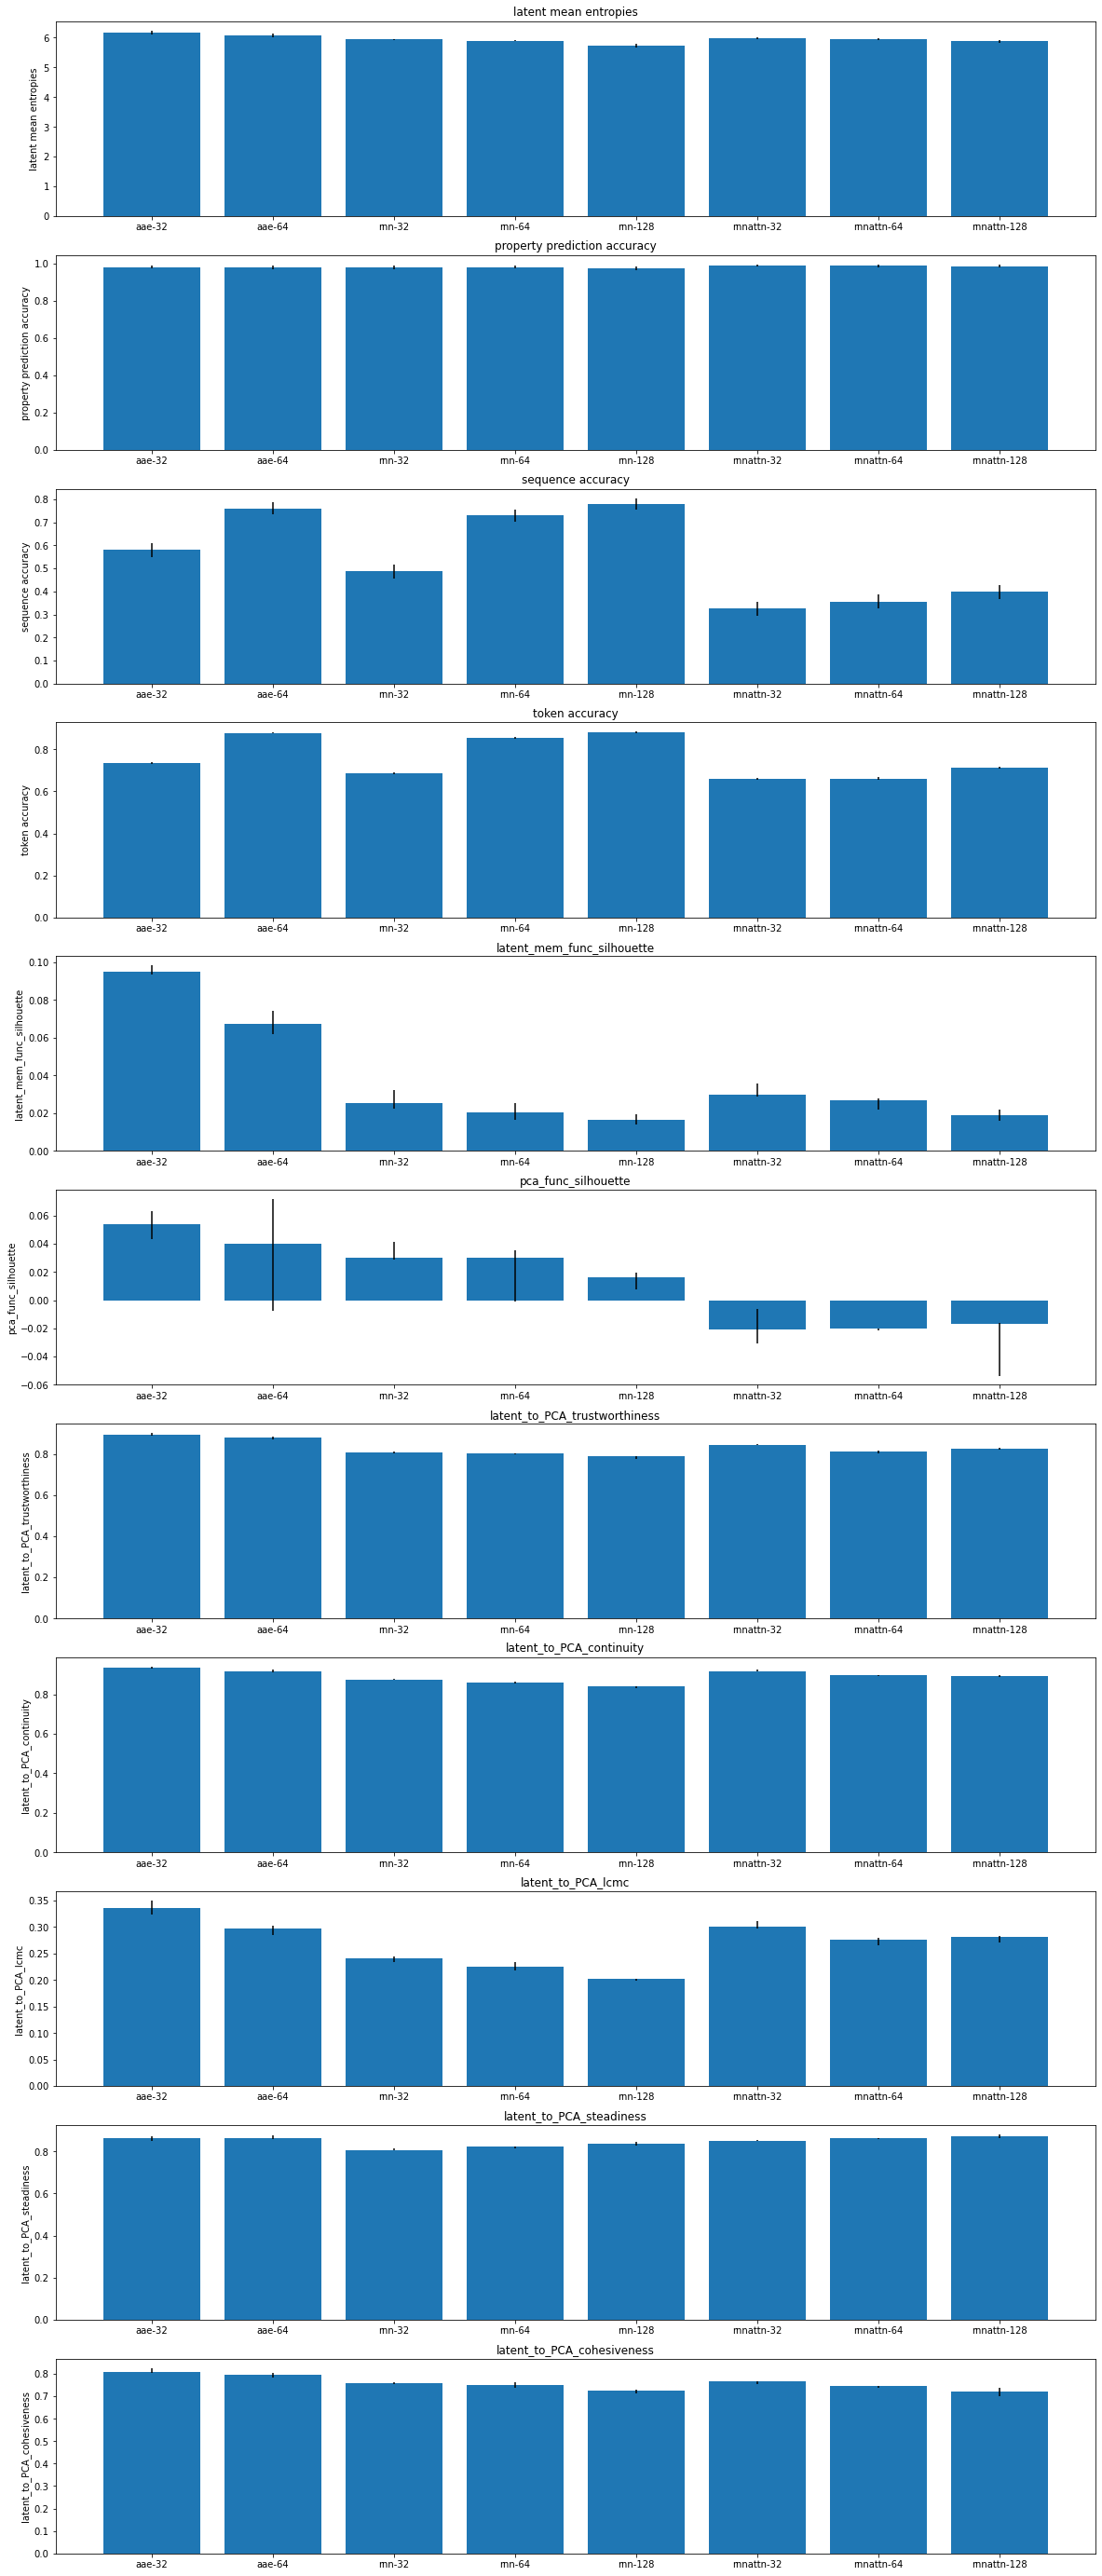

In [6]:
fig, ax = plt.subplots((len(metric_list)//len(namelist)-1),1, figsize=(20,50))

for col in range((len(metric_list)//len(namelist)-1)):
    ax[col].bar(x=model_names,height=[elmt[0] for elmt in metric_list[col::(len(metric_list)//len(namelist))]],
                yerr=[[elmt[1] for elmt in metric_list[col::(len(metric_list)//len(namelist))]],
                      [elmt[2] for elmt in metric_list[col::(len(metric_list)//len(namelist))]]]) 
    ax[col].set_title(metric_list[col::(len(metric_list)//len(namelist))][0][-1])
    ax[col].set_ylabel('{}'.format(metric_list[col::(len(metric_list)//len(namelist))][0][-1]))
plt.savefig('bar_metrics.jpg', transparent=None)
plt.show()

In [11]:
pos_acc_list = []
pos_err_list = []
for df_tuple in df_list:
    #grab 1st element of cols: 2->last
    pos_acc_list.append(df_tuple[0].loc[:,df_tuple[0].columns[0]])
    pos_err_list.append(df_tuple[0].loc[:,df_tuple[0].columns[1]])


In [18]:
#plt.errorbar(x=range(len(pos_accs)),y=pos_accs,xerr=0,yerr=pos_conf,fmt='none',ecolor='r',elinewidtlen(h=0.6)
len(pos_acc_list[0].dropna()),len(pos_err_list[0].dropna())

(87, 87)

IndexError: list index out of range

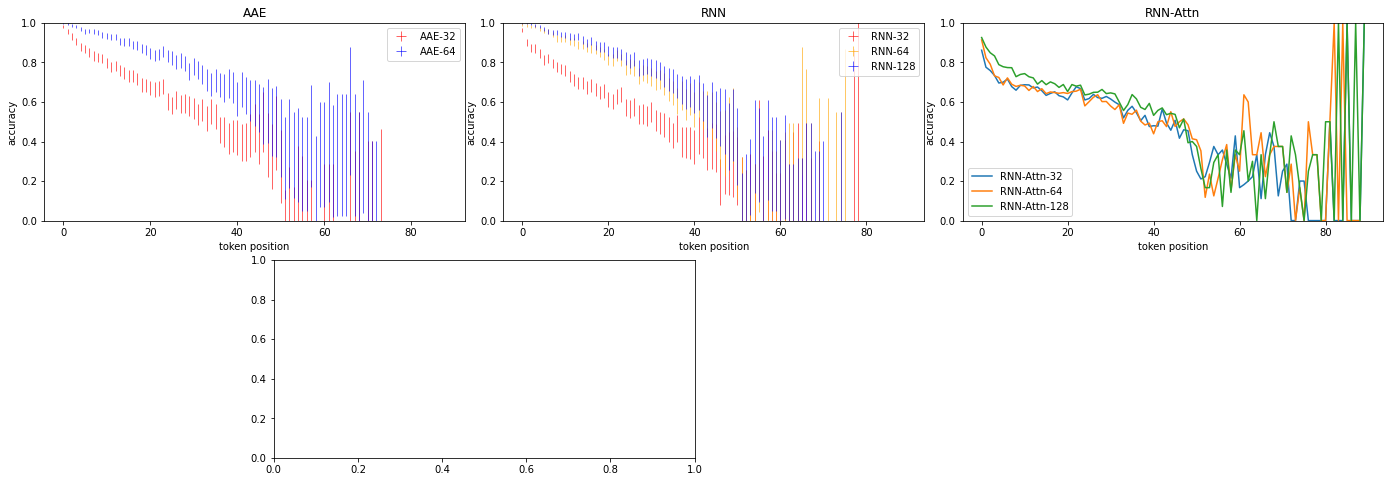

In [33]:
fig = plt.figure(figsize=(24,8))

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
# img = plt.plot(range(len(pos_acc_list[0].dropna())),pos_acc_list[0].dropna(),
#                range(len(pos_acc_list[1].dropna())),pos_acc_list[1].dropna())
ax1.errorbar(x=range(len(pos_acc_list[0].dropna())), y=pos_acc_list[0].dropna(),
                   xerr=0,yerr=pos_err_list[0].dropna(),fmt='none',ecolor='r',elinewidth=0.6)
ax1.errorbar(x=range(len(pos_acc_list[1].dropna())), y=pos_acc_list[1].dropna(),
                   xerr=0,yerr=pos_err_list[1].dropna(),fmt='none',ecolor='b',elinewidth=0.6)
ax1.set_title('AAE')
ax1.legend(['AAE-32','AAE-64'])
ax1.set_ylim([0, 1])
ax1.set_ylabel('accuracy')
ax1.set_xlabel('token position')
# plt.show(img)

ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax2.errorbar(x=range(len(pos_acc_list[2].dropna())), y=pos_acc_list[2].dropna(),
                   xerr=0,yerr=pos_err_list[2].dropna(),fmt='none',ecolor='r',elinewidth=0.6)
ax2.errorbar(x=range(len(pos_acc_list[3].dropna())), y=pos_acc_list[3].dropna(),
                   xerr=0,yerr=pos_err_list[3].dropna(),fmt='none',ecolor='orange',elinewidth=0.6)
ax2.errorbar(x=range(len(pos_acc_list[4].dropna())), y=pos_acc_list[4].dropna(),
                   xerr=0,yerr=pos_err_list[4].dropna(),fmt='none',ecolor='b',elinewidth=0.6)
ax2.set_title('RNN')
ax2.legend(['RNN-32','RNN-64','RNN-128'])
ax2.set_ylim([0, 1])
ax2.set_ylabel('accuracy')
ax2.set_xlabel('token position')
# plt.show(img)

ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
img = plt.plot(range(len(pos_acc_list[5].dropna())),pos_acc_list[5].dropna(),
               range(len(pos_acc_list[6].dropna())),pos_acc_list[6].dropna(),
               range(len(pos_acc_list[7].dropna())),pos_acc_list[7].dropna())
ax3.set_title('RNN-Attn')
ax3.legend(['RNN-Attn-32','RNN-Attn-64','RNN-Attn-128'])
ax3.set_ylim([0, 1])
ax3.set_ylabel('accuracy')
ax3.set_xlabel('token position')
# plt.show(img)

ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
img = plt.plot(range(len(pos_acc_list[8].dropna())),pos_acc_list[8].dropna(),
               range(len(pos_acc_list[9].dropna())),pos_acc_list[9].dropna(),
               range(len(pos_acc_list[10].dropna())),pos_acc_list[10].dropna())
ax4.set_title('Trans-1x')
ax4.legend(['Trans-32','Trans-64','Trans-128'])
ax4.set_ylim([0, 1])
ax4.set_ylabel('accuracy')
ax4.set_xlabel('token position')
# plt.show(img)

ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
img = plt.plot(range(len(pos_acc_list[11].dropna())),pos_acc_list[11].dropna(),
               range(len(pos_acc_list[12].dropna())),pos_acc_list[12].dropna())
ax5.set_title('WAE')
ax5.legend(['WAE-32','WAE-64'])
ax5.set_ylim([0, 1])
ax5.set_ylabel('accuracy')
ax5.set_xlabel('token position')
plt.savefig('position_acc.png', transparent=None)
plt.show(img)

